#### Credits to Foam Liu https://github.com/foamliu/Car-Recognition

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input/devkit/devkit"))

import scipy.io
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
import cv2#reading and resizing                      
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from resnet import resnet18,resnet34, resnet50, resnet101, resnet152
from resnet import load_trained_model

# Prepare Data

In [3]:
meta_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_meta.mat')
train_annos_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_train_annos.mat')
test_annos_dict = scipy.io.loadmat('Cars_Dataset_Stanford/car_devkit/devkit/cars_test_annos.mat')
annos_dict = [train_annos_dict,test_annos_dict]

In [4]:
# Load cars_meta into dataFrame
meta_df = pd.DataFrame.from_dict(meta_dict['class_names'])
meta_df = meta_df.stack()
len(meta_df)

196

In [5]:
# Load train and test annos into dataFrame
for i,d in enumerate(annos_dict):
    r,c = d['annotations'].shape
    d_reshape = d['annotations'].reshape(c,r)
    d_reshape.shape
    
    if i == 0:
        d_df = pd.DataFrame(data = np.hstack((d_reshape[:]['bbox_x1'],d_reshape[:]['bbox_y1'],d_reshape[:]['bbox_x2'],
                                            d_reshape[:]['bbox_y2'],d_reshape[:]['class'],d_reshape[:]['fname'])))
        d_df.rename(index=str,columns={0:'bbox_x1',1:'bbox_y1',2:'bbox_x2',3:'bbox_y2',4:'class',5:'fname'},inplace=True)
    else:
        d_df = pd.DataFrame(data = np.hstack((d_reshape[:]['bbox_x1'],d_reshape[:]['bbox_y1'],d_reshape[:]['bbox_x2'],
                                            d_reshape[:]['bbox_y2'],d_reshape[:]['fname'])))
        d_df.rename(index=str,columns={0:'bbox_x1',1:'bbox_y1',2:'bbox_x2',3:'bbox_y2',4:'fname'},inplace=True)

    for col in d_df.columns:
        l = d_df[col]  
        flatten = lambda l: [item for sublist in l for item in sublist]
        if col == 'fname':
            pass
        else:
            d_df[col] = d_df[col].apply(flatten)

        d_df[col] = d_df[col].apply(lambda i: i[0])
    
    if i == 0:
        train_annot_df = d_df.copy()
    else:
        test_annot_df = d_df.copy()

# Split data to train, evaluation and test

In [6]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

C:\Users\HP\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\HP\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\HP\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [7]:
X = train_annot_df.drop('class',axis=1)
y = train_annot_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

train_df = pd.concat([X_train,y_train],axis=1)
val_df = pd.concat([X_val,y_val],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

In [8]:
# Convert column class to string
train_df['class'] = train_df['class'].apply(str)
val_df['class'] = val_df['class'].apply(str)
test_df['class'] = test_df['class'].apply(str)

In [9]:
print(train_annot_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(8144, 6)
(3990, 6)
(1710, 6)
(2444, 6)


In [10]:
image_gen = ImageDataGenerator(rotation_range=30, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

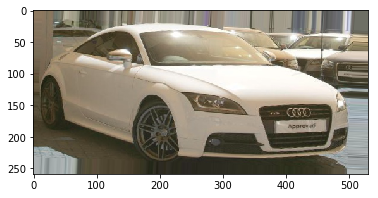

In [11]:
img = cv2.imread('Cars_Dataset_Stanford/cars_train_cropped/00001.jpg')
plt.imshow(image_gen.random_transform(img))
#plt.imshow(img)

# Find image size median

In [12]:
# Find median of image size
height_list = []
width_list = []

for i in range(len(train_annot_df)):
    path = 'Cars_Dataset_Stanford/cars_train_cropped/' + train_annot_df['fname'][i]
    img = cv2.imread(path)
    height,width = img.shape[:2]
    height_list.append(height)
    width_list.append(width)

In [13]:
img_height = int(np.median(height_list))
img_width = int(np.median(width_list))

print(img_height)
print(img_width)

260
504


In [14]:
image_shape = (img_height, img_width,3)

# Creating the Model

In [15]:
'''
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer
model.add(Dense(196))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
'''

"\nmodel = Sequential()\n\nmodel.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\n\nmodel.add(Flatten())\n\n\nmodel.add(Dense(128))\nmodel.add(Activation('relu'))\n\n# Dropouts help reduce overfitting by randomly turning neurons off during training.\n# Here we say randomly turn off 50% of neurons.\nmodel.add(Dropout(0.5))\n\n# Last layer\nmodel.add(Dense(196))\nmodel.add(Activation('softmax'))\n\nmodel.compile(loss='categorical_crossentropy',\n              optimizer='rmsprop',\n              metrics=['accuracy'])\n"

In [16]:
n_classes = len(meta_df)

model = resnet18(image_shape,n_classes)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#model.summary()

# Training the Model

In [18]:
patience = 50
verbose = 1
batch_size = 16
num_epochs = 100000
patience = 50

In [19]:
tensor_board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
log_file_path = 'logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_acc', patience=patience)
reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
trained_models_path = 'models/model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]

In [20]:
batch_size = 16

train_generator = image_gen.flow_from_dataframe(
                    dataframe = train_df,
                    directory = 'Cars_Dataset_Stanford/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2]
                    )

Found 3990 validated image filenames belonging to 196 classes.


In [21]:
valid_generator = image_gen.flow_from_dataframe(
                    dataframe = val_df,
                    directory = 'Cars_Dataset_Stanford/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2]
                    )

Found 1710 validated image filenames belonging to 196 classes.


In [22]:
test_generator = image_gen.flow_from_dataframe(
                    dataframe = test_df,
                    directory = 'Cars_Dataset_Stanford/cars_train_cropped/',
                    x_col = 'fname',
                    y_col = 'class',
                    class_mode = 'categorical',
                    batch_size = batch_size,
                    target_size=image_shape[:2])

Found 2444 validated image filenames belonging to 196 classes.


In [23]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

3990
1710
2444


In [24]:
num_train_samples = len(train_df)
num_valid_samples = len(val_df)
num_test_samples = len(test_df)

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2508693559813178416
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2213819187
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15899923547668024906
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [26]:
weights_path = 'C:/Users/HP/Documents/Machine Learning/Grab_AI_Challenge/models/'
weights_file = 'model.45-0.17.hdf5'
model.load_weights(weights_path + weights_file)

In [27]:
# fine tune the model
results =   model.fit_generator(
            train_generator,
            steps_per_epoch=num_train_samples / batch_size,
            validation_data=valid_generator,
            validation_steps=num_valid_samples / batch_size,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=verbose)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100000
250/249 [==============================] - 158s 633ms/step - loss: 1.5012 - acc: 0.6463 - val_loss: 7.4440 - val_acc: 0.0696

Epoch 00001: val_acc improved from -inf to 0.06959, saving model to models/model.01-0.07.hdf5
Epoch 2/100000
250/249 [==============================] - 151s 604ms/step - loss: 1.4254 - acc: 0.6666 - val_loss: 5.7311 - val_acc: 0.1041

Epoch 00002: val_acc improved from 0.06959 to 0.10409, saving model to models/model.02-0.10.hdf5
Epoch 3/100000
250/249 [==============================] - 153s 611ms/step - loss: 1.3581 - acc: 0.6840 - val_loss: 5.1357 - val_acc: 0.1228

Epoch 00003: val_acc improved from 0.10409 to 0.12281, saving model to models/model.03-0.12.hdf5
Epoch 4/100000
250/249 [==============================] - 150s 602ms/step - loss: 1.2921 - acc: 0.6954 - val_loss: 4.2465 - val_acc: 0.1637

Epoch 00004: val_acc improved from 0.12281 to 0.16374, saving model to models/model.04-0.16.hdf5
Epo

KeyboardInterrupt: 

In [42]:
df_meta_df = pd.DataFrame(meta_df, columns = ["Car Make"])
df_meta_df

Car Make
0 0                         [AM General Hummer SUV 2000]
  1                                [Acura RL Sedan 2012]
  2                                [Acura TL Sedan 2012]
  3                               [Acura TL Type-S 2008]
  4                               [Acura TSX Sedan 2012]
  5                          [Acura Integra Type R 2001]
  6                           [Acura ZDX Hatchback 2012]
  7           [Aston Martin V8 Vantage Convertible 2012]
  8                 [Aston Martin V8 Vantage Coupe 2012]
  9               [Aston Martin Virage Convertible 2012]
  10                    [Aston Martin Virage Coupe 2012]
  11                        [Audi RS 4 Convertible 2008]
  12                                [Audi A5 Coupe 2012]
  13                               [Audi TTS Coupe 2012]
  14                                [Audi R8 Coupe 2012]
  15                                [Audi V8 Sedan 1994]
  16                               [Audi 100 Sedan 1994]
  17                               [Audi 100 Wagon 1994]
  18                            [Audi TT Hatchback 2011]
  19                                [Audi S6 Sedan 2011]
  20                          [Audi S5 Convertible 2012]
  21                                [Audi S5 Coupe 2012]
  22                                [Audi S4 Sedan 2012]
  23                                [Audi S4 Sedan 2007]
  24                             [Audi TT RS Coupe 2012]
  25                     [BMW ActiveHybrid 5 Sedan 2012]
  26                     [BMW 1 Series Convertible 2012]
  27                           [BMW 1 Series Coupe 2012]
  28                           [BMW 3 Series Sedan 2012]
  29                           [BMW 3 Series Wagon 2012]
...                                                  ...
  166                     [Mitsubishi Lancer Sedan 2012]
  167                       [Nissan Leaf Hatchback 2012]
  168                     [Nissan NV Passenger Van 2012]
  169                       [Nissan Juke Hatchback 2012]
  170                          [Nissan 240SX Coupe 1998]
  171                         [Plymouth Neon Coupe 1999]
  172                      [Porsche Panamera Sedan 2012]
  173                   [Ram C/V Cargo Van Minivan 2012]
  174  [Rolls-Royce Phantom Drophead Coupe Convertibl...
  175                     [Rolls-Royce Ghost Sedan 2012]
  176                   [Rolls-Royce Phantom Sedan 2012]
  177                          [Scion xD Hatchback 2012]
  178                       [Spyker C8 Convertible 2009]
  179                             [Spyker C8 Coupe 2009]
  180                          [Suzuki Aerio Sedan 2007]
  181                        [Suzuki Kizashi Sedan 2012]
  182                        [Suzuki SX4 Hatchback 2012]
  183                            [Suzuki SX4 Sedan 2012]
  184                         [Tesla Model S Sedan 2012]
  185                          [Toyota Sequoia SUV 2012]
  186                          [Toyota Camry Sedan 2012]
  187                        [Toyota Corolla Sedan 2012]
  188                          [Toyota 4Runner SUV 2012]
  189                   [Volkswagen Golf Hatchback 2012]
  190                   [Volkswagen Golf Hatchback 1991]
  191                 [Volkswagen Beetle Hatchback 2012]
  192                         [Volvo C30 Hatchback 2012]
  193                             [Volvo 240 Sedan 1993]
  194                              [Volvo XC90 SUV 2007]
  195                    [smart fortwo Convertible 2012]

[196 rows x 1 columns]